CC Cet science that doesn't fit into another notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Table of pceb parameters

In [3]:
wdtab = Table.read('../tables/pceb_fit_results.csv')

In [4]:
wdtab

Target,Teff,e_Teff,logg,e_logg,si,si_e,c,c_e,o,o_e,s,s_e
str11,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
V-UZ-SEX,17146,15,7.801,0.007,-7.08,0.03,-6.21,0.05,-6.44,0.07,-7.36,0.3
V-LM-COM,28878,1122,7.358,0.1,-6.96,0.04,-5.9,0.04,-5.63,0.0,-6.96,0.0
WD-1339+606,37074,76,7.449,0.005,-7.88,0.4,-8.32,0.1,-8.05,0.4,-7.34,0.8
WD-1504+546,21730,53,7.67,0.01,-7.13,0.2,-8.25,0.09,-8.15,0.3,-7.43,0.6
WD-2317+268,28403,19,7.585,0.005,-6.78,0.03,-5.82,0.03,-4.66,0.1,-6.65,0.2
WD-1436-216,22814,38,7.658,0.01,-7.19,0.05,-6.27,0.1,-5.92,0.4,-8.18,0.1
WD-1458+171,21406,4,7.445,0.0003,-6.19,0.3,-5.09,0.04,-5.96,0.0,-6.51,0.0
WD2257+162,22886,33,7.24,0.008,-7.38,0.05,-6.27,0.05,-8.03,0.5,-7.34,0.1
WD2256+249,21488,17,7.73,0.006,-6.88,0.02,-5.76,0.02,-5.72,0.05,-7.39,0.2


Not sure why I filtered so many targets out? Do for now.

In [5]:
cc_cet1 = dict(Teff=25245, e_Teff=19, logg=7.6059, e_logg=0.005)
cc_cet2 = dict(Teff=25162, e_Teff=20, logg=7.564, e_logg=0.005)
print(25245-25162)
print(7.6059-7.564)
cc_cet = dict(Teff=(25245+25162)/2, e_Teff=(25245-25162), logg=np.log10(((10**7.6059)+(10**7.564))/2), e_logg=7.6059-7.564)

eggr38 = dict(Teff=16970, e_Teff=16, logg=7.9244, e_logg=0.008)

lm_com = dict(Teff=28878, e_Teff=1122, logg=7.358, e_logg=0.1)

#estimate eteff and ellog from average of the CC Cet and LM com  fractional errors
frac_t_e = np.mean([(lm_com['e_Teff']/lm_com['Teff']), (cc_cet['e_Teff']/cc_cet['Teff'])])
frac_g_e = np.mean([(lm_com['e_logg']/lm_com['logg']), (cc_cet['e_logg']/cc_cet['logg'])])
print(frac_t_e, frac_g_e)


83
0.04190000000000005
0.021073149788232617 0.00955718942426105


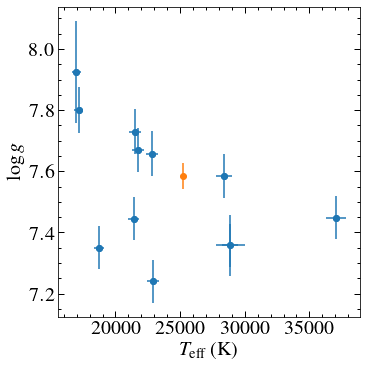

In [6]:
plt.figure(figsize=(5.5,5.5))
plt.errorbar(wdtab['Teff'], wdtab['logg'], xerr = wdtab['e_Teff'], yerr= wdtab['e_logg'], ls='none', marker='o', c='C0')
plt.errorbar(wdtab['Teff'], wdtab['logg'], xerr = wdtab['Teff']*frac_t_e, yerr= wdtab['logg']*frac_g_e, ls='none', marker='o', c='C0')
plt.errorbar(eggr38['Teff'], eggr38['logg'], xerr = eggr38['e_Teff'], yerr= eggr38['e_logg'], ls='none', marker='o', c='C0')
plt.errorbar(eggr38['Teff'], eggr38['logg'], xerr = eggr38['Teff']*frac_t_e, yerr= eggr38['logg']*frac_t_e, ls='none', marker='o', c='C0')

plt.errorbar(cc_cet['Teff'], cc_cet['logg'], xerr = cc_cet['e_Teff'], yerr= cc_cet['e_logg'], ls='none', marker='o', c='C1')

plt.xlabel('$T_{\mathrm{eff}}$ (K)')
plt.ylabel('$\log g$')
plt.tight_layout()
plt.savefig('plots/teffvlogg.pdf')

In [7]:
z = 1.96
n = 13
x = 1

pd = (x/n)
c = z*((pd*(1-pd))/n)**0.5
print(pd*100, c*100)

q = 1+((z**2)/n)
p2 = (pd+(z**2/(2*n)))/q
c = (z/q) * (((pd*(1-pd))/n) + (z**2/(4*n**2)))**0.5
print(p2*100, c*100)

ph = np.arcsin(pd**0.5)
iu = (np.sin(ph - (z/(2*n**0.5))))**2
print(iu*100)

7.6923076923076925 14.485439144214036
17.342770283108493 15.971763645138862
0.008522380892296472


In [8]:
import astropy.stats

In [9]:
bs = astropy.stats.binned_binom_proportion([np.arange(13)], [False, False,False,False,False,False,False,False,False, False, False, False, True], 
                                      bins=1, interval='flat')#, confidence_level=0.68)
print(bs)
print(bs[2]*100)
print(bs[3]*100)

(array([6.]), array([6.]), array([0.07692308]), array([[0.02577488],
       [0.14018613]]))
[7.69230769]
[[ 2.57748811]
 [14.01861336]]


In [10]:
bs

(array([6.]),
 array([6.]),
 array([0.07692308]),
 array([[0.02577488],
        [0.14018613]]))

Magnetic moment and spin

In [11]:
B = 700*1e3*u.G
R = 0.0179*u.Rsun
mu = B*((R.to(u.cm))**3)
print(mu)
#(B*R).to(u.G/u.cm**3)
mdot = (10**(-10.5))*(u.Msun/ u.yr)


1.3518333084616032e+33 cm3 G


In [12]:
qb = (0.5-(0.227*np.log10(0.5)))**(3/2)
q =0.17
qr = (0.5-(0.227*np.log10(q)))**(3/2)
print(qr/qb)

1.2934490679831134


In [13]:
#from their figure 2 I get pspin/porb
prmin = 0.02
#prmax =0.2

#need our q
mprim = 0.441
mpe = 0.008
msec =0.18
mse = 0.05
msec2 = 0.08

eq = ((mpe/mprim)**2 + (mse/msec)**2)**2

q = msec2/mprim
print(q)
print(q*eq)

qr = (0.5-(0.227*np.log10(q)))**(3/2)
qrat = qr/qb  
print(qrat)

prat = prmin*qrat
print(prat)
#print(prmax*qrat)

print('here')
porb_range = [1.14, 1.24]
for p in porb_range:
    porb = p*u.hour
    print(porb.to(u.min))
    pspin = porb*prat
    print(pspin)
    print(pspin.to(u.minute))
    print(pspin.to(u.minute)*eq)

0.18140589569160998
0.001089276046318624
1.2750829424328338
0.025501658848656676
here
68.39999999999999 min
0.029071891087468608 h
1.7443134652481165 min
0.01047396429824901 min
74.4 min
0.03162205697233428 h
1.8973234183400567 min
0.01139273309634103 min


Wind rate: Need to work out accretion rate, see if the magentic field gets it all via prescription in https://ui.adsabs.harvard.edu/abs/2005ASPC..330..137W/abstract.

In [14]:
#-5.6, -6.1
si_ab = np.log10(np.mean([10**-5.6, 10**-6.1]))
print(si_ab)                          

-5.781698947597886


In [15]:
mwd = 0.441*u.Msun
hmass = 1e-4 *mwd
q = -15.625
#tdiff = (10**-1.207)*u.yr
tdiff = -1.207
#mdot = ((10**si_ab)*(hmass.to(u.g)))/(tdiff.to(u.s))
rate = si_ab + np.log10(mwd.value) + q +np.log10(28.085/1.008)- tdiff
mdot_si = ((10**rate)*u.M_sun/u.yr).to(u.g/u.s)
print(mdot_si)
si_sun = 6.649E-04
mdot = mdot_si /si_sun
print(mdot)

4888273.325086731 g / s
7351892502.762418 g / s


In [16]:
a = 1.6*u.Rsun
B0 = 670.0e3*u.G
rwd = 0.0179*u.Rsun
Bmd = B0*(rwd/a)**3
print(Bmd)

0.938153596191406 G


In [17]:
uB = Bmd**2/(8*np.pi)
print(uB.value) #this is an energy because the internet says so?

0.0350193463592889


In [18]:
m2 = 0.18*u.Msun
r2 = 0.243*u.Rsun
omg = const.G*(m2.to(u.kg))/(r2.to(u.m))
omg = omg.to(u.erg/u.g)
print(omg)

1413044575407663.0 erg / g


In [19]:
#107ergcm°2s°1:
Fx = 1e7*u.erg/u.cm**2/u.s
esp = Fx/omg
print(esp)

7.0769175821045865e-09 g / (cm2 s)


In [20]:
vesc = (2*const.G*m2/r2)**0.5
#vesc = vesc.to(u.km/u.s)
print(vesc.to(u.km/u.s))
vesc = vesc.to(u.cm/u.s)
mu_wind = esp*vesc
mu_wind = mu_wind.to(u.erg/u.cm**3) 
print(mu_wind)

531.6097394532316 km / s
0.37621583119546137 erg / cm3


So energy in the wind ~10* energy in M field at wd. Not helpful given uncertaintes. When does it become more, and is it less than B-H radius?

In [21]:
#bond 
radb = (2*const.G*mwd)/vesc**2
radb = radb.to(u.Rsun) 
print(radb)

0.5953499999999997 solRad


(0.0179, 1.3570000000000002)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


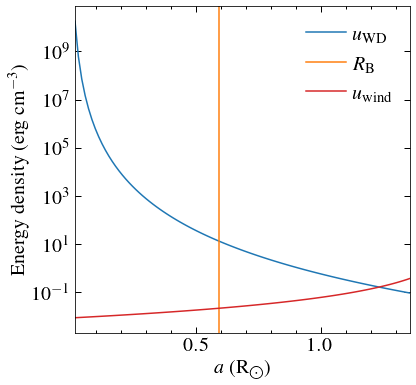

In [22]:
plt.figure(figsize=(6, 6))
brange = np.linspace(rwd, a-r2, 100)
Br = (np.array([B0.value*(rwd/ai)**3 for ai in brange])**2)/(8*np.pi)
plt.plot(brange, Br, label = '$u_{\mathrm{WD}}$')
plt.yscale('log')
plt.axvline(radb.value, c='C1', label = '$R_{\mathrm B}$')
#plt.axhline(mu_wind.value, c='C3', label = '$u_{0\,\mathrm{wind}}$')
crange = np.linspace(r2, a-rwd, 100)
#mus = []
#for ai in crange:
uwind = np.array([mu_wind.value*(r2/ai)**2 for ai in crange])
 #   vesc = ((2*const.G*m2/ai)**0.5).to(u.cm/u.s)
  #  mus.append((esp*vesc).value)
plt.plot(a-crange, uwind, c='C3', label= '$u_{\mathrm{wind}}$')
plt.xlabel(r'$a$ (R$_{\bigodot}$)')
plt.ylabel('Energy density (erg cm$^{-3}$)')
plt.legend()
plt.xlim(rwd.value, a.value-r2.value)
#plt.xlim(1.23, 1.245)
#plt.ylim(1.e-1, 4e-1)

In [23]:
rcrit = 1.2*u.Rsun

In [24]:
rcrit/a

<Quantity 0.75>

In [25]:
mwind = mdot/(rcrit/a)**2
print(mdot)
print(mwind)

7351892502.762418 g / s
13070031116.02208 g / s


In [26]:
#mwind_bh = mdot*(((a.to(u.cm))**2)*(vesc**4))/(((const.G.to(u.cm**3/u.g/u.s**2))**2)*mwd.to(u.g))
#print(mwind_bh)

m_loss = (((2*a*m2)/(r2*mwd))**2) * mdot
print(m_loss)

212399939649.546 g / s


In [27]:
m_loss/mwind

<Quantity 16.25091308>

In [28]:
mwind.to(u.Msun/u.yr)

<Quantity 2.07431486e-16 solMass / yr>

In [29]:
m_loss.to(u.Msun/u.yr)

<Quantity 3.37095105e-15 solMass / yr>

In [30]:
np.mean([630, 710])

670.0

In [31]:
v = 40*u.km/u.s
prot = 2*np.pi*rwd/v
#prot
prot.to(u.min)

<Quantity 32.6019563 min>

Syncronisation timescale

In [32]:
#def tsync():
 #   I = (2/5) * M1*R1**2
  #  q = M1/M2
   # ts = (1 / (6*q*k2)) * ((M1*R1**2)/L)**(1/3) * (I/(M1*R1))**2 * (a/R1)**6  

Comparison with Preps

In [33]:
preptab = np.genfromtxt('preps.csv', delimiter=',', dtype=None, names=True, encoding=None)

In [34]:
preptab

array([('SDSS J030308.35+005444.1',  -1, -1,  8, False,   9150, 193.6, 0.84, '143'),
       ('SDSS J083751.0+383012.5',  -1, -1, -1, False,     -1, 178.8,  nan, '87'),
       ('HS 0922+1333',  66, 81, -1, False,  -8000, 242.4,  nan, '144 145 146'),
       ('WX LMi (=HS 1023+3900 )',  61, 70, -1, False,     -1, 166.9,  nan, '147 148 149'),
       ('IL Leo (=SDSS J103100.55+202832.2)',  42, -1, -1, False,   9500,  83.2,  nan, '150'),
       ('SDSS J105905.06+272755.4',  57, -1, -1, False,  -8500, 150. ,  nan, '150'),
       ('SDSS J120615.73+510047.0', 108, -1, -1, False,   9000, 197. ,  nan, '151'),
       ('PZ Vir (=J132411.57+032050.4)',  63, -1, -1, False,  -7500, 158.7,  nan, '152 153 154'),
       ('MQ Dra (=SDSS J155331.11+551614.4)',  58, -1, -1, False, -10000, 263.5,  nan, '152 154'),
       ('SDSS J204827.91+005008.9',  62, -1, -1, False,   7500, 252. ,  nan, '154')],
      dtype=[('Name', '<U34'), ('B_cyc_1_MG', '<i8'), ('B_cyc_2_MG', '<i8'), ('B_Zeem_phot_MG', '<i8'), ('B_Zee

In [35]:
preptab.dtype.names

('Name',
 'B_cyc_1_MG',
 'B_cyc_2_MG',
 'B_Zeem_phot_MG',
 'B_Zeem_halo_MG',
 'T_eff_K',
 'P_rot_min',
 'Mass_M⊙',
 'References_notes')

In [36]:
preptab['T_eff_K']

array([  9150,     -1,  -8000,     -1,   9500,  -8500,   9000,  -7500,
       -10000,   7500])

In [37]:
ptab = preptab[preptab['T_eff_K'] !=-1]

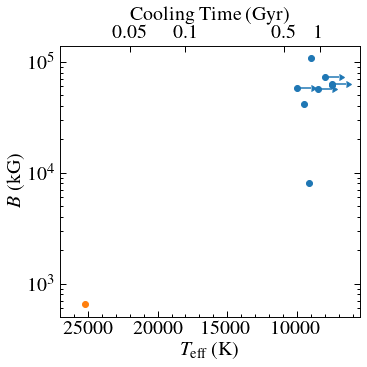

In [38]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))

for i, star in enumerate(ptab['Name']):
    mags = np.array([ptab['B_cyc_1_MG'][i], ptab['B_cyc_2_MG'][i], ptab['B_Zeem_phot_MG'][i], ptab['B_Zeem_halo_MG'][i]])
    mags = mags[mags >0]
    mags = np.mean(mags*1e3)
    #print(mags)
    teff = ptab['T_eff_K'][i]
    x = abs(teff)
    if teff > 0:
        plt.errorbar(x, mags, ls='none', marker='o', c='C0')
    else: 
        plt.errorbar(x, mags, ls='none', marker='o', xlolims=True, xerr = -1000, c='C0')
cc_mags = 650
cc_teff = 25203 
cc_teff_e = 42
plt.errorbar(cc_teff, cc_mags, ls='none', marker='o', xerr = cc_teff_e, c='C1')
ax.set_yscale('log')
#plt.xscale('log')
plt.xlabel('$T_{\mathrm{eff}}$ (K)')
plt.ylabel('$B$ (kG)')


xlims = [27000, 5500]
plt.xlim(xlims[0], xlims[1])

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off 

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    left=True,
    right=True)      # ticks along the bottom edge are off 


ax2 = ax.twiny()
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off  

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    left=True,
    right=True)      # ticks along the bottom edge are off 

ages = ['1', '0.5', '0.1', '0.05']
tage = [8400, 10950, 18000, 22000]

ax2.set_xticks(tage)#, minor=False)
ax2.set_xticklabels(ages)

ax2.set_xlim(xlims[0], xlims[1])
ax2.set_xlabel('Cooling Time (Gyr)')
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('plots/teffvB.pdf', dpi=150)


Get approximate ages from a Bergeron table

In [39]:
agetab = np.genfromtxt('/media/david/5tb_storage1/cc_cet/misc/Table_Mass_0.6.txt', names=True, skip_header=1, skip_footer=74)

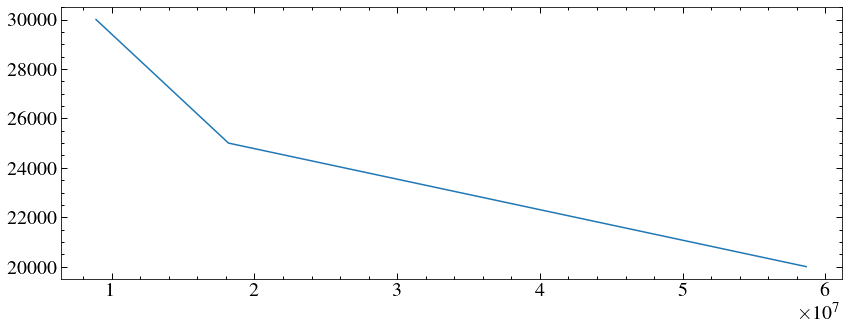

In [40]:
teff, age = agetab['Teff'], agetab['Age']
#mask = (age > 0.05e9) & (age < 0.2e9)
mask = (teff > 19000) & (teff < 31000) 
plt.plot(age[mask], teff[mask])

How much of an outlier?

In [41]:
bstat = []
tstat = []
tpos = []

for i, star in enumerate(ptab['Name']):
    mags = np.array([ptab['B_cyc_1_MG'][i], ptab['B_cyc_2_MG'][i], ptab['B_Zeem_phot_MG'][i], ptab['B_Zeem_halo_MG'][i]])
    mags = mags[mags >0]
    mags = np.mean(mags*1e3)
    #print(mags)
    teff = ptab['T_eff_K'][i]
    bstat.append(mags)
    tstat.append(abs(teff))
    if teff > 0:
        tpos.append(teff)
    
print(np.mean(bstat), np.std(bstat))
print(np.mean(tstat), np.std(tstat))

print(((np.mean(np.log10(bstat)))-np.log10(cc_mags))/np.std(np.log10(bstat)))
print(abs(np.mean(tpos)-cc_teff)/np.std(tpos))

58937.5 26294.530681303288
8643.75 866.5439616661118
5.924748782407588
21.453702596772317


In [42]:
def binom_stat(n, s):
    x = np.arange(n)
    result = np.zeros(n-s, dtype=bool)
    result = np.append(result, np.ones(s, dtype=bool))
    bs = astropy.stats.binned_binom_proportion([x], [result], bins=1, interval='flat')#, confidence_level=0.68)
    #print(bs)
    print(bs[2]*100)
    print(bs[3]*100)

binom_stat(13, 1)
binom_stat(1735, 0)
binom_stat(1200, 2)

[7.69230769]
[[ 2.57748811]
 [14.01861336]]
[0.]
[[0.        ]
 [0.10599351]]
[0.16666667]
[[0.05279033]
 [0.21907613]]


Spin-orbit ratio

In [43]:
rwd

<Quantity 0.0179 solRad>

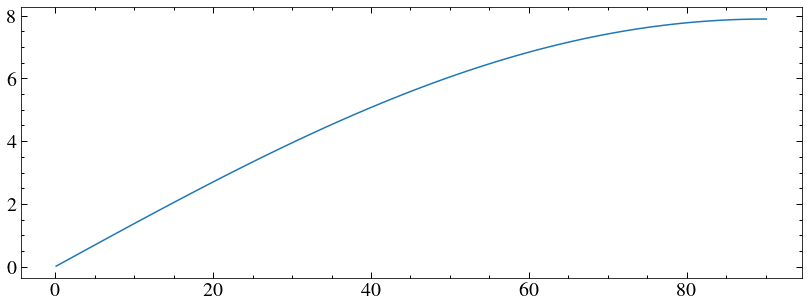

In [44]:
v = 40*u.km/u.s #sini
#prot = 2*np.pi*rwd/v
porb = 6.8818*u.hr

sins = np.arange(0.1, 91)* np.pi / 180.
pspins = []
for i  in sins:
    pspins.append(((2*np.pi*rwd*np.sin(i))/v).to(u.min).value)
pspins = np.array(pspins)*u.min               
# pspins = np.array([((2*np.pi*rwd/(v*np.sin(i))).to(u.min) for i in sins])
#pspins

plt.plot(sins*180/np.pi, pspins/porb.to(u.min)*100)
#np.sin(np.pi/4)*v


In [45]:
np.sin(np.pi/2)

1.0

Adding parsons+21 to the b v teff plot

In [46]:
p21tab = np.genfromtxt('parsons+21.csv', delimiter=',', dtype=None, names=True, encoding=None)
p21tab.dtype.names

('Name', 'Teff', 'B1', 'B2')

85857.14285714286 67085.88008010665
9117.857142857143 1956.2726167434867
6.039463501625154
6.4363941018360515


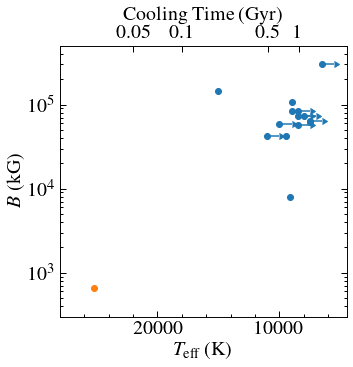

In [47]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))


bstat = []
tstat = []
tpos = []

for i, star in enumerate(ptab['Name']):
    mags = np.array([ptab['B_cyc_1_MG'][i], ptab['B_cyc_2_MG'][i], ptab['B_Zeem_phot_MG'][i], ptab['B_Zeem_halo_MG'][i]])
    mags = mags[mags >0]
    mags = np.mean(mags*1e3)
    #print(mags)
    teff = ptab['T_eff_K'][i]
    x = abs(teff)
    if teff > 0:
        plt.errorbar(x, mags, ls='none', marker='o', c='C0')
    else: 
        plt.errorbar(x, mags, ls='none', marker='o', xlolims=True, xerr = -1000, c='C0')
    bstat.append(mags)
    tstat.append(abs(teff))
    if teff > 0:
        tpos.append(teff)
        
for i, star in enumerate(p21tab['Name']):
    mags = np.array([p21tab['B1'][i], p21tab['B2'][i]])
    mags = mags[mags >0]
    mags = np.mean(mags*1e3)
    #print(mags)
    teff = p21tab['Teff'][i]
    x = abs(teff)
    if teff > 0:
        plt.errorbar(x, mags, ls='none', marker='o', c='C0')
    else: 
        plt.errorbar(x, mags, ls='none', marker='o', xlolims=True, xerr = -1000, c='C0')
    bstat.append(mags)
    tstat.append(abs(teff))
    if teff > 0:
        tpos.append(teff)
        
        
        
cc_mags = 650
cc_teff = 25203 
cc_teff_e = 42
plt.errorbar(cc_teff, cc_mags, ls='none', marker='o', xerr = cc_teff_e, c='C1')
ax.set_yscale('log')
#plt.xscale('log')
plt.xlabel('$T_{\mathrm{eff}}$ (K)')
plt.ylabel('$B$ (kG)')


xlims = [28000, 4500]
plt.xlim(xlims[0], xlims[1])

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off 

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    left=True,
    right=True)      # ticks along the bottom edge are off 


ax2 = ax.twiny()
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top=False)      # ticks along the bottom edge are off  

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    left=True,
    right=True)      # ticks along the bottom edge are off 

ages = ['1', '0.5', '0.1', '0.05']
tage = [8400, 10950, 18000, 22000]

ax2.set_xticks(tage)#, minor=False)
ax2.set_xticklabels(ages)

ax2.set_xlim(xlims[0], xlims[1])
ax2.set_xlabel('Cooling Time (Gyr)')
ax2.set_yscale('log')

plt.ylim(3e2, 5e5)

#can I add gradients?

plt.tight_layout()
# plt.savefig('plots/teffvB.pdf', dpi=150)

print(np.mean(bstat), np.std(bstat))
print(np.mean(tstat), np.std(tstat))

print(((np.mean(np.log10(bstat)))-np.log10(cc_mags))/np.std(np.log10(bstat)))
print(abs(np.mean(tpos)-cc_teff)/np.std(tpos))

In [48]:
bstat = []
tstat = []
tpos = []

for i, star in enumerate(ptab['Name']):
    mags = np.array([ptab['B_cyc_1_MG'][i], ptab['B_cyc_2_MG'][i], ptab['B_Zeem_phot_MG'][i], ptab['B_Zeem_halo_MG'][i]])
    mags = mags[mags >0]
    mags = np.mean(mags*1e3)
    #print(mags)
    teff = ptab['T_eff_K'][i]
    bstat.append(mags)
    tstat.append(abs(teff))
    if teff > 0:
        tpos.append(teff)
    
for i, star in enumerate(p21tab['Name']):
    mags = np.array([p21tab['B1'][i], p21tab['B2'][i]])
    mags = mags[mags >0]
    mags = np.mean(mags*1e3)
    #print(mags)
    teff = p21tab['Teff'][i]
    bstat.append(mags)
    tstat.append(abs(teff))
    if teff > 0:
        tpos.append(teff)
   
print(np.mean(bstat), np.std(bstat))
print(np.mean(tstat), np.std(tstat))

print(((np.mean(np.log10(bstat)))-np.log10(cc_mags))/np.std(np.log10(bstat)))
print(abs(np.mean(tpos)-cc_teff)/np.std(tpos))

85857.14285714286 67085.88008010665
9117.857142857143 1956.2726167434867
6.039463501625154
6.4363941018360515


(array([1., 0., 0., 0., 2., 4., 4., 1., 1., 1.]),
 array([3.90308999, 4.06049311, 4.21789624, 4.37529937, 4.53270249,
        4.69010562, 4.84750875, 5.00491187, 5.162315  , 5.31971813,
        5.47712125]),
 <BarContainer object of 10 artists>)

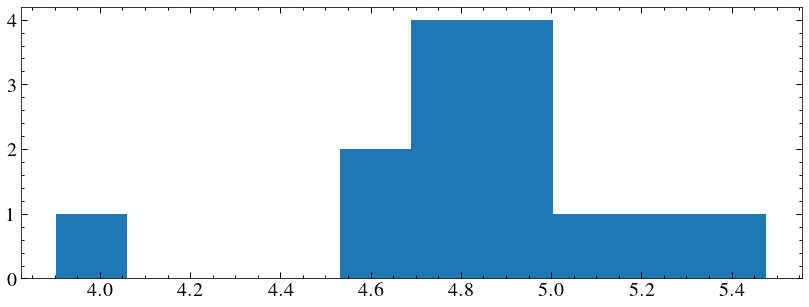

In [49]:
plt.hist(np.log10(bstat))

(array([1., 3., 5., 2., 1., 1., 0., 0., 0., 1.]),
 array([ 6500.,  7350.,  8200.,  9050.,  9900., 10750., 11600., 12450.,
        13300., 14150., 15000.]),
 <BarContainer object of 10 artists>)

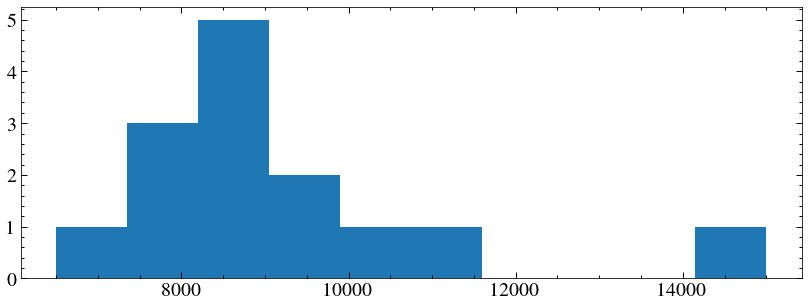

In [50]:
plt.hist(tstat)